# Radio ML Classification - ANN Approach

Solution to the RadioML classification challenge using ANNs.

In [ ]:
# Loading Data

pathToDataset = "C:/Users/aksha/Documents/Jupyter Notebooks/radioml-classification/Datasets/Standard/RML2016.10a_dict.pkl"

# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open(pathToDataset,'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Description of Data

The dataset has the size 220,000×2×128, which means that there are 220,000 entries, each consisting of an array of size 2 × 128. Each array represents the samples of about 128 µs of a received waveform sampled with approximately 106 samples/second, and it contains between 8 and 16 modulation symbols. Since the samples of the signal waveforms are complex-valued, they have been stored as real and imaginary parts, and therefore we have arrays of size 2 × 128 in the data set.

That is, each row is essentially, **a + ib**.

The labels of the downloaded dataset contain two parameters: the modulation technique used (one of [’8PSK’, ’AM-DSB’, ’AM-SSB’, ’BPSK’,’CPFSK’, ’GFSK’, ’PAM4’, ’QAM16’, ’QAM64’, ’QPSK’, ’WBFM’], so 11 possible modulation techniques), and the signal-to noise ratio (SNR) value (one of [−20, −18, −16, −14, −12, −10, −8, −6, −4, −2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18], so 20 possible SNR values). The SNR is a measure for the quality of the communication channel. The higher the SNR, the less “noisy” is the channel.

Each item of the list is essentially like **(b'Modulation Type',SNR Value)**

In [ ]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np
import scipy.stats as sp

# Data Processing

The goal of this stage is to split data into Training, Validation and Testing data and then process the available data and transform (if needed) it into relevant inputs to be fed into the ANN.

1. Split Dataset into Training, Validation and Testing Data : 110,000 samples for training and validation and 110,000 samples for testing.

2. Write a function to process data and extract features which are fed into the ANN. (Refer ANN-1 Paper for Features)

In [ ]:
#  into training and test sets of the form we can train/test on 
random.seed(777)
np.random.seed(777)

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]

# Create Validation Data Set
indexVal = np.arange(0,110000)
random.shuffle(indexVal)

realTrainIdx = indexVal[0:99000] 
valIdx = indexVal[99000:110000]

# Actual Training Data
realTrainX = trainX[realTrainIdx]

# Actual Validation Data
validX = trainX[valIdx]

# Actual Testing Data
testX = X[testIdx]

In [ ]:
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
ytrain = lbl_encoded[trainIdx]
y_train = ytrain[realTrainIdx]
y_valid = ytrain[valIdx]
y_test=lbl_encoded[testIdx]

In [ ]:
# Helper Methods

# Normalize By Mean
def normalizeMean(data):
    meanData = np.mean(data,axis=2)
    
    dataReal = data[:,0,:]
    meanReal = (np.array([meanData[:,0]])).T
    normalReal = dataReal/meanReal
    
    dataImag = data[:,1,:]
    meanImag = (np.array([meanData[:,1]])).T
    normalImag = dataImag/meanImag
    
    return normalReal, normalImag

# Compute Instantaneous Amplitude (or Magnitude)
def instAmp(data):
    return np.linalg.norm(data,axis=1)

# Function for Raw Moment
def rawMoment(data,n):
    # Calculate the nth Raw Moment of The Data
    dataRaised = np.power(data,n)
    nthMoment = np.array([np.mean(dataRaised,axis=1)])
    
    return nthMoment.T

# Function for (x+y)th Order Moment
def highOrdMoment(data,x,y):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    complexDataConj = np.conj(complexData) # Complex Conjugate
    
    finDat = np.power(complexData,x-y)*np.power(complexDataConj,y)
    
    finDatMean = np.array([np.mean(finDat,axis=1)]).T
    
    return finDatMean

In [ ]:
# Feature Extraction Methods

test = np.array([[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]]) # Test Data

# Feature 1: Ratio of Real and Complex Power

def betaRatio(data):
    sumOfSquares = np.sum(np.square(data),axis=2)
    beta = sumOfSquares[:,1]/sumOfSquares[:,0] # Q / I
    beta = np.array([beta])
    beta = beta.T
    return beta

# Feature 2: Standard Deviation of Direct Instantaneous Phase [IMP: Consider Noise Threshold]

def sigmaDP(data,n):
    # n is a flag for normalization
    # n = 1 : Normalize
    
    if(n==0):
        dataReal = data[:,0,:]
        dataImag = data[:,1,:]
    
    if(n==1):
        dataReal, dataImag = normalizeMean(data)
    
    # Perform I / R
    tanArg = dataImag/dataReal
    
    # ArcTan | Instantaneous Phase
    phase = np.arctan(tanArg)
    
    # Standard Deviation of Phase
    sigDP = np.array([np.std(phase,axis=1)])
    
    return phase, sigDP.T # Also Returns Phase for Use Later

# Feature 3: Standard Deviation of Absolute Value of Non Linear Component of Instantaneous Phase
def sigmaAP(data,n):
    # n is a flag for normalization
    # n = 1 : Normalize
    
    if(n==0):
        dataReal = data[:,0,:]
        dataImag = data[:,1,:]
    
    if(n==1):
        dataReal, dataImag = normalizeMean(data)
    
    # Perform I / R
    tanArg = dataImag/dataReal
    
    # ArcTan | Instantaneous Phase
    phase = np.arctan(tanArg)
    phase = np.abs(phase)
    
    # Standard Deviation of Phase
    sigAP = np.array([np.std(phase,axis=1)])
    
    return sigAP.T

# Feature 4: Standard Deviation of Absolute Value of Normalized Instantaneous Amplitude

# Absolute of Magnitude Basically
    
def sigmaAA(data):
    instAmplitude = instAmp(data)
    
    # Sepcial Normalization
    meanInstAmplitude = (np.array([np.mean(instAmplitude,axis=1)])).T
    normInstAmplitude = (instAmplitude / meanInstAmplitude) - 1 # This is acn
    
    # Find Absolute of acn
    normInstAmplitude = np.abs(normInstAmplitude)
    
    sigAA = np.array([np.std(normInstAmplitude,axis=1)])
    
    return sigAA.T

# Feature 5: Standard Deviation of Absolute Normalized Centered Instantaneous Frequency

# Less Accurate Estimate Using First Differences
def sigmaAF(phase):
    
    # Compute Instantaneous Frequency
    instFrequency = np.diff(phase) # Approximation of Derivative
    
    # Normalize and Center
    meanInstFrequency = (np.array([np.mean(instFrequency,axis=1)])).T
    normInstFrequency = (instFrequency / meanInstFrequency) - 1
    
    # Find Absolute
    normInstFrequency = np.abs(normInstFrequency)
    
    # Find Standard Deviation
    sigAF = np.array([np.std(normInstFrequency,axis=1)])
    
    return sigAF.T

# Feature 6: Standard Deviation of Absolute Value of Instantaneous Amplitude (Normalized w.r.t Variance)
def sigmaV(data):
    instAmplitude = instAmp(data)
    
    # Normalize w.r.t Variance
    varInstAmplitude = (np.array([np.var(instAmplitude,axis=1)])).T
    normInstAmplitude = np.sqrt(instAmplitude/varInstAmplitude) - 1
    
    # Find Absolute
    normInstAmplitude = np.abs(normInstAmplitude)
    
    # Find Standard Deviation
    sigV = np.array([np.std(normInstAmplitude,axis=1)])
    
    return sigV.T

# Feature 7: Mixed Order Moments [M(4,2) / M(2,1)]
def genV20(data):
    instAmplitude = instAmp(data)
    
    moment4 = rawMoment(instAmplitude,4)
    moment2 = rawMoment(instAmplitude,2) # Typo in Paper, Squared?
    
    return moment4 / moment2

# Feature 8: Mean of Signal Magnitude
def meanMag(data):
    instAmplitude = instAmp(data)
    meanMagnitude = np.array([np.mean(instAmplitude,axis=1)])
    
    return meanMagnitude.T

# Feature 9: Normalized Square Root of Sum of Amplitudes
def normRootSumAmp(data):
    instAmplitude = instAmp(data)
    sumAmpl = np.array([np.sum(instAmplitude,axis=1)]).T
    normRoot = np.sqrt(sumAmpl)/instAmplitude.shape[1]
    
    return normRoot

# Feature 10: Max PSD of Normalized Centered Amplitude
def maxPSD(data):
    instAmplitude = instAmp(data)
    # Compute DFT
    ampDFT = np.fft.fft(instAmplitude,axis=1)
    # Compute Magnitude Spectrum
    magAmpDFT = np.abs(ampDFT)
    # Power Spectrum
    powDFT = np.square(magAmpDFT)
    # Max Power
    maxPow = np.array([np.max(powDFT,axis=1)]).T
    
    return maxPow / maxPow.shape[0]

# Feature 11: Cumulant C20
def getC20(data):
    m20 = highOrdMoment(data,2,0)
    return np.abs(m20)

# Feature 12: Cumulant C21
def getC21(data):
    m21 = highOrdMoment(data,2,1)
    return np.abs(m21)

# Feature 13: Cumulant C40
def getC40(data):
    m40 = highOrdMoment(data,4,0)
    m20 = highOrdMoment(data,2,0)
    c40 = m40 - (3*np.square(m20))
    
    return np.abs(c40)
    
# Feature 14: Cumulant C41
def getC41(data):
    m41 = highOrdMoment(data,4,1)
    m21 = highOrdMoment(data,2,1)
    m20 = highOrdMoment(data,2,0)
    
    c41 = m41 - (3*m20*m21)
    
    return np.abs(c41)
    
# Feature 15: Cumulant C42
def getC42(data):
    m42 = highOrdMoment(data,4,2)
    m21 = highOrdMoment(data,4,2)
    m20 = highOrdMoment(data,2,0)
    
    c42 = m42 - np.square(m20) - (2*np.square(m21))
    
    # Norm Code
    c21 = getC21(data)
    c42Norm = c42 / np.square(c21)
    
    return np.abs(c42Norm)

# Feature 16: Cumulant C63
def getC63(data):
    m63 = highOrdMoment(data,6,3)
    m20 = highOrdMoment(data,2,0)
    m21 = highOrdMoment(data,2,1)
    m22 = highOrdMoment(data,2,2)
    m40 = highOrdMoment(data,4,0)
    m41 = highOrdMoment(data,4,1)
    m42 = highOrdMoment(data,4,2)
    
    t1 = m63 - (9*m21*m42) + (12*np.power(m21,3))
    #t2 = (-3*m20*m42)-(3*m22*m41)
    #t3 = 18*m20*m21*m22
    
    t2 = (-6*m20*m40) + (18*np.square(m20)*m21) 
    
    #c63 = t1+t2+t3
    c63 = t1+t2
    
    return np.abs(c63)

# Feature 17: Cumulant C80
def getC80(data):
    m80 = highOrdMoment(data,8,0)
    m60 = highOrdMoment(data,6,0)
    m40 = highOrdMoment(data,4,0)
    m20 = highOrdMoment(data,2,0)
    
    t1 = m80 - (35*np.square(m40))
    t2 = (-28*m60*m20) + (420*m40)
    t3 = (-630*np.power(m20,4))
    
    c80 = t1+t2+t3
    
    return np.abs(c80)

# Feature 18: Kurtosis
def getKurtosis(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    meanComplexData = np.array([np.mean(complexData,axis=1)]).T
    
    # Find fourth central moment
    fourthPower = np.power(complexData - meanComplexData,4)
    centralMoment4 = (np.array([np.sum(fourthPower,axis=1)]).T)/fourthPower.shape[1]
    
    # Variance
    var = np.array([np.var(complexData,axis=1)]).T
    
    kurt = np.abs(centralMoment4)/(np.square(var)) # var already abs
    
    return kurt

# Feature 19: Skewness
def getSkewness(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    meanComplexData = np.array([np.mean(complexData,axis=1)]).T
    
    # Find third central moment
    thirdPower = np.power(complexData - meanComplexData,3)
    centralMoment3 = (np.array([np.sum(thirdPower,axis=1)]).T)/thirdPower.shape[1]
    
    # Standard Deviation
    std = np.array([np.std(complexData,axis=1)]).T
    
    skew = np.abs(centralMoment3)/(np.power(std,3)) # std already abs
    
    return skew

# Feature 20: Peak to RMS Ratio
def getPR(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    absSquare = np.square(np.abs(complexData))
    absSquareMax = np.array([np.max(absSquare,axis=1)]).T
    
    # Calculate RMS (without Root)
    rms = np.array([np.mean(absSquare,axis=1)]).T # Consider Abs of Mean?
    
    # Calculate PR
    PR = absSquareMax/rms
    
    return PR

# Feature 21: Peak to Average Ratio
def getPA(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    absData = np.abs(complexData)
    absMax = np.array([np.max(absData,axis=1)]).T
    
    # Calculate Mean
    meanData = np.array([np.mean(absData,axis=1)]).T # Consider Abs of Mean?
    
    # Calculate PA
    PA = absMax / meanData
    
    return PA

In [7]:
# Function to Generate Input vector

def createIPVector(data):
    beta = betaRatio(data)
    sigPhase, sigDp = sigmaDP(data,1)
    sigAp = sigmaAP(data,1)
    sigAa = sigmaAA(data)
    sigAF = sigmaAF(sigPhase)
    sigV = sigmaV(data)
    v20 = genV20(data)
    meanMagX = meanMag(data)
    X2 = normRootSumAmp(data)
    gammaMax = maxPSD(data)
    
    cumulantC20 = getC20(data)
    cumulantC21 = getC21(data)
    cumulantC40 = getC40(data)
    cumulantC41 = getC41(data)
    cumulantC42 = getC42(data)
    cumulantC63 = getC63(data)
    cumulantC80 = getC80(data)
    
    kurtosis = getKurtosis(data)
    skewness = getSkewness(data)
    
    pr = getPR(data)
    pa = getPA(data)

    # Concat
    #xtrainIP = np.concatenate((beta,sigDp,sigAp,sigAa,sigAF,sigV,v20,meanMagX,X2,gammaMax,cumulantC20,cumulantC21,cumulantC40,cumulantC41,cumulantC42,cumulantC63,cumulantC80,kurtosis,skewness,pr,pa),axis=1)
    xtrainIP = np.concatenate((cumulantC20,cumulantC21,cumulantC40,cumulantC41,cumulantC42,cumulantC63,cumulantC80,kurtosis,skewness,pr,pa),axis=1)
    return xtrainIP

# Generate Training, Validation and Testing Input Vectors
xtrainIP = createIPVector(realTrainX)
#xtrainIP = np.expand_dims(xtrainIP, axis=-1) # Important

xvalidIP = createIPVector(validX)

xtestIP = createIPVector(testX)
#xtestIP = np.expand_dims(xtestIP, axis=-1) # Important

# Design Neural Network

In [31]:
# Network Parameters

# Structure
numInput = 11 # Number of Input Nodes
numHid1 = 2048 # Number of Nodes in the First Hidden Layer
numHid2 = 1024 # Number of Nodes in the Second Hidden Layer
numHid3 = 512  # Number of Nodes in the Third Hidden Layer
numHid4 = 256  # Number of Nodes in the Fourth en Layer
numHid5 = 128  # Number of Nodes in the Fifth Hidden Layer
numOutput = 11 # Number of Output Nodes

# Weight Initialization
weightInit = 'glorot_uniform' # Xavier Initialization

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
#netOptimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
netOptimizer = 'adam'

# Callbacks
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('Data/ANN-9/ANN-9-Weights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')]

# Construct Network
model = models.Sequential()
#model.add(BatchNormalization(axis=-1,input_shape=(11,), name='Normalization_1'))
#model.add(LayerNormalization(input_shape=(numInput,), name='Normalization'))
#model.add(Dense(numHid1, activation=activationHidden, kernel_initializer=weightInit, name='Hidden_Layer_1'))
model.add(Dense(2048,input_shape=(numInput,), activation=activationHidden, name='Hidden_Layer_1'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation=activationHidden, name='Hidden_Layer_2'))
model.add(Dropout(0.5))
model.add(Dense(512, activation=activationHidden, name='Hidden_Layer_3'))
model.add(Dropout(0.5))
#model.add(Dense(40, activation=activationHidden, name='Hidden_Layer_4'))
#model.add(Dropout(0.5))
#model.add(Dense(20, activation=activationHidden, name='Hidden_Layer_5'))
#model.add(Dropout(0.5))
model.add(Dense(numOutput, activation=activationOutput, name='Output_Layer'))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 2048)              24576     
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
Output_Layer (Dense)         (None, 11)               

# Train Network

In [32]:
# Train Model
history = model.fit(xtrainIP, y_train, batch_size=1000, epochs=100, verbose=2, validation_data=(xvalidIP,y_valid),callbacks=callbackList)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 2s - loss: 2.0465 - categorical_accuracy: 0.2622 - val_loss: 1.7938 - val_categorical_accuracy: 0.3711
Epoch 2/100
99000/99000 - 1s - loss: 1.7622 - categorical_accuracy: 0.3680 - val_loss: 1.7084 - val_categorical_accuracy: 0.3912
Epoch 3/100
99000/99000 - 1s - loss: 1.7103 - categorical_accuracy: 0.3844 - val_loss: 1.6752 - val_categorical_accuracy: 0.3955
Epoch 4/100
99000/99000 - 1s - loss: 1.6970 - categorical_accuracy: 0.3864 - val_loss: 1.6606 - val_categorical_accuracy: 0.4047
Epoch 5/100
99000/99000 - 1s - loss: 1.6826 - categorical_accuracy: 0.3935 - val_loss: 1.6583 - val_categorical_accuracy: 0.4035
Epoch 6/100
99000/99000 - 1s - loss: 1.6755 - categorical_accuracy: 0.3940 - val_loss: 1.6508 - val_categorical_accuracy: 0.4055
Epoch 7/100
99000/99000 - 1s - loss: 1.6690 - categorical_accuracy: 0.3977 - val_loss: 1.6378 - val_categorical_accuracy: 0.4068
Epoch 8/100
99000/99000 - 1s - loss: 1.6635 - c

In [33]:
# Save History
np_loss_history = np.array(history.history["loss"])
np.save('Data/ANN-9/lossHist.npy',np_loss_history)

np_accu_history = np.array(history.history["categorical_accuracy"])
np.save('Data/ANN-9/accuHist.npy',np_accu_history)

np_val_loss_history = np.array(history.history["val_loss"])
np.save('Data/ANN-9/valLossHist.npy',np_val_loss_history)

np_val_accu_history = np.array(history.history["val_categorical_accuracy"])
np.save('Data/ANN-9/valAccuHist.npy',np_val_accu_history)

# Test/Evaluate Network

In [34]:
# Re-load Best Weights
model.load_weights('Data/ANN-9/ANN-9-Weights_best.h5')

model.evaluate(xtestIP,y_test)

110000/110000 [==============================] - 7s 61us/sample - loss: 1.5672 - categorical_accuracy: 0.4258


[1.5671530471281572, 0.42578182]

# Visualaize Results

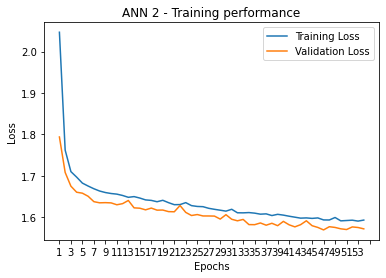

In [35]:
# Load Details of History
lHist = np.load('Data/ANN-9/lossHist.npy')
aHist = np.load('Data/ANN-9/accuHist.npy')

vLHist = np.load('Data/ANN-9/valLossHist.npy')
vAHist = np.load('Data/ANN-9/valAccuHist.npy')

# Show loss curves 
plt.figure()
plt.title('ANN 2 - Training performance')
plt.plot(lHist, label='Training Loss')
plt.plot(vLHist, label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,len(lHist)+1,2),np.arange(1,len(lHist)+1,2))
plt.ylabel('Loss')
plt.legend()

In [36]:
# Function to Extract Test Data of Specific SNR
def extractTest(data,labels,labelsEncoded,testIndex,snr):
    testData = data[testIndex]
    labelArray = np.array([labels])
    testLabels = labelArray[:,testIdx,:]
    testLabelsEncoded = labelsEncoded[testIdx]
    
    idxOP = list()
    
    # Loop Through Label Array To Get Index of Specific SNR
    for i in range(0,testLabels.shape[1]):
        if testLabels[0,i,1].decode('ascii')==snr:
            idxOP.append(i)
    
    # Return Subset of Test Data and Corresponding Labels
    opTestData = testData[idxOP,:,:]
    opTestLabel = testLabelsEncoded[idxOP]
    
    return opTestData, opTestLabel

def plot_confusion_matrix(cm, titleAdd, title='ANN 2 - Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+titleAdd)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix Function
def prepConfMat(testData,testLabel,predTestLabel,mods,title):
    modString = list()
    for i in range(0,len(mods)):
        modString.append(mods[i].decode('ascii'))
    
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,testData.shape[0]):
        j = list(testLabel[i,:]).index(1)
        k = int(np.argmax(predTestLabel[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, title, labels=modString)

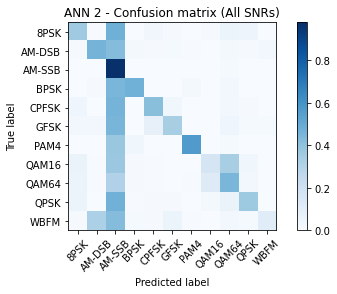

In [37]:
# Plot confusion matrix
test_Y_hat = model.predict(xtestIP, batch_size=1024)

prepConfMat(xtestIP,y_test,test_Y_hat,mods,' (All SNRs)')

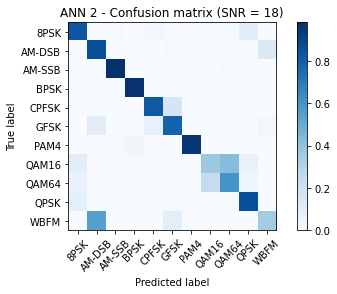

In [38]:
# Plot Confusion Matrix for Specific SNR
snr = '18'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)

xtestSNRFeat = createIPVector(x_testSNR)

y_hat_snr = model.predict(xtestSNRFeat, batch_size=1024)
prepConfMat(xtestSNRFeat,y_TestSNR,y_hat_snr,mods,title)

In [39]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i_temp = testX[np.where(y_test_snr==snr)]
    test_X_i = createIPVector(test_X_i_temp)
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09389079113353757 for SNR b'-20'
Overall Accuracy:  0.09277414669571532 for SNR b'-18'
Overall Accuracy:  0.08871410279860983 for SNR b'-16'
Overall Accuracy:  0.09218181818181818 for SNR b'-14'
Overall Accuracy:  0.09153030030570042 for SNR b'-12'
Overall Accuracy:  0.1039485766758494 for SNR b'-10'
Overall Accuracy:  0.13412192902638762 for SNR b'-8'
Overall Accuracy:  0.16996402877697842 for SNR b'-6'
Overall Accuracy:  0.22405271828665568 for SNR b'-4'
Overall Accuracy:  0.33696053116931024 for SNR b'-2'
Overall Accuracy:  0.4780259365994236 for SNR b'0'
Overall Accuracy:  0.5986057604109337 for SNR b'2'
Overall Accuracy:  0.68272157564906 for SNR b'4'
Overall Accuracy:  0.7315931593159316 for SNR b'6'
Overall Accuracy:  0.7559479553903345 for SNR b'8'
Overall Accuracy:  0.7666968325791855 for SNR b'10'
Overall Accuracy:  0.7715485756026297 for SNR b'12'
Overall Accuracy:  0.7734948604992657 for SNR b'14'
Overall Accuracy:  0.7719170607493634 for SNR b'16'
Over

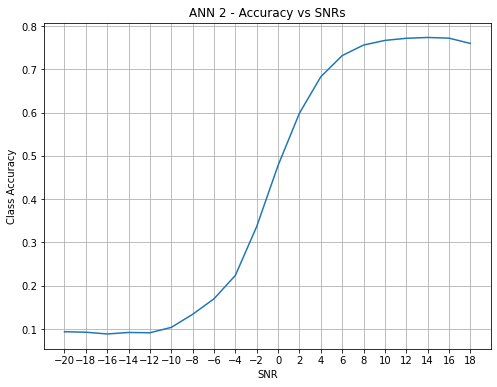

In [40]:
# Show loss curves 
plt.figure(figsize=(8, 6))
plt.title('ANN 2 - Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)
plt.xlabel('SNR')
plt.xticks(np.arange(-20,20,2))
plt.ylabel('Class Accuracy')
plt.grid()
plt.show()

In [41]:
accRes = np.array([acc_array])
np.save('Data/ANN-9/accResSNR.npy',accRes)